# Counting Transcripts - Extension

> This is part four of the Counting Transcripts series. We will use the knowledge from the previous parts to evaluate differentially expressed transcripts. This notebook should be located in the same folder as the previous notebooks.

## Setup

> As usual, we will first need to setup our working directory.

In [1]:
###IMPORTANT: if you ever restart this notebook, you MUST rerun this code cell
import os

#feel free to change this location, because we will be working in this folder for the entire tutorial
os.environ['WORKDIR'] = './data' 

## Extension 1: Evaluating differentially expressed transcripts 

From this one sample, we can see that some transcripts are expressed more or less than other transcripts, but this data does not give any insight about the effect of changes in transcript abundance and cellular behavior. This is why we need to compare the transcript expression of different samples. For example, imagine we would like to address the following question: which transcripts are responsible for making this a cancerous cell? We would look at the transcript expression between a normal cell and a cancerous cell, and analyze transcripts that are differentially expressed between the two samples. In this extension, we will begin looking at differentially expressed transcripts by visualizing the levels of transcription between different samples.

We will continue to use samples from the adaptive prediction paper ([PMID 28854640](https://www.ncbi.nlm.nih.gov/pubmed/28854640)) to analyze the effects of caffeine on yeast at the transcriptome level. 

Before we download the data from the other samples, let us clean our working directories. For the following folders `$WORKDIR/BAM/`, `$WORKDIR/cleanFASTQ/`, `$WORKDIR/cufflinks/`, `$WORKDIR/FASTQ/`, and `$WORKDIR/kallisto/`, create new folders in each folder specifying the experiment (1a, 1c, 2a, 2c, 3a, 3c). In the pipeline tutorials, we were working with data from 1a, so move any existing files into your new 1a folder. However, in the kallisto folder, leave the transcripts.idx file under /data/kallisto because we can reuse the kallisto index and it should be shared between the samples.

For example, your `$WORKDIR/kallisto/` folder should look something like this:
<html>
<div style="width: 50%;margin: 0 auto; background-color: rgb(242, 242, 242);">
    <code><i>kallisto</i>/
    transcripts.idx
    1a/
        abundance.h5
        abundance.tsv
        run_info.json
    1c/
    2a/
    2c/
    3a/
    3c/</code>
</div>
</html>

We will now download the sequencing data from replicate 1 after caffeine, replicate 2 before and after caffeine, and replicate 3 before and after caffeine. Research scientists use replicates to check that outcomes are not due to chance. This is different from a trial, because a **trial** refers to a certain action performed many times repeatedly using the exact same object, while a **replicate** would perform a certain action on many of the same object. 

An example of a trial is flipping the same coin three times, while replicates would be flipping three different coins.


| Replicate # | Before Caffeine (a) | After Caffeine (c) |
| --- | --- | --- |
| 1 | [SRX2785036](https://www.ncbi.nlm.nih.gov/sra/SRX2785036[accn]) | [SRX2785039](https://www.ncbi.nlm.nih.gov/sra/SRX2785039[accn]) |
| 2 | [SRX2785037](https://www.ncbi.nlm.nih.gov/sra/SRX2785037[accn]) | [SRX2785040](https://www.ncbi.nlm.nih.gov/sra/SRX2785040[accn]) |
| 3 | [SRX2785038](https://www.ncbi.nlm.nih.gov/sra/SRX2785038[accn]) | [SRX2785041](https://www.ncbi.nlm.nih.gov/sra/SRX2785041[accn]) |

SRA toolkit provides a very easy to use executable called `prefetch`, which we can call to help us download the sequencing data files. All we have to do is provide the SRA accession, a unique identifier provided by the [NCBI](https://www.ncbi.nlm.nih.gov/) for each sample.

In [ ]:
!prefetch SRX2785037
!prefetch SRX2785038
!prefetch SRX2785039
!prefetch SRX2785040
!prefetch SRX2785041

These files usually download automatically to a new location, the `~/ncbi/public/sra/` folder, so lets move all the files to our /data/seqData folder.

In [ ]:
!mv -v  ~/ncbi/public/sra/* $WORKDIR/seqData

Using the same procedure as above, let's generate metrics to measure the level of gene expression in each experiment. Feel free to reference above if you need help, but **remember to change file names and locations**.

1. convert to FASTQ
2. clean the reads
3. map the reads to the reference transcriptome sequence (we already generated the transcriptomeIndex, so no need to do it again!)
4. quantify the aligned reads

If you get stuck, here is the list of commands to run:

In [ ]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/2a $WORKDIR/seqDATA/SRR5511058.sra

In [ ]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/3a $WORKDIR/seqDATA/SRR5511059.sra

In [ ]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/1c $WORKDIR/seqDATA/SRR5511060.sra

In [ ]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/2c $WORKDIR/seqDATA/SRR5511061.sra

In [ ]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/3c $WORKDIR/seqDATA/SRR5511062.sra

In [ ]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/2a/SRR5511058_1.fastq $WORKDIR/FASTQ/2a/SRR5511058_2.fastq \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [ ]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/3a/SRR5511059_1.fastq $WORKDIR/FASTQ/3a/SRR5511059_2.fastq \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [ ]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/1c/SRR5511060_1.fastq $WORKDIR/FASTQ/1c/SRR5511060_2.fastq \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [ ]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/2c/SRR5511061_1.fastq $WORKDIR/FASTQ/2c/SRR5511061_2.fastq \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [ ]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/3c/SRR5511062_1.fastq $WORKDIR/FASTQ/3c/SRR5511062_2.fastq \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [ ]:
!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/2a \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/3a \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/1c \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/2c \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/3c \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_paired.fastq

We now have the gene expression in 6 different samples in terms of TPM. A common first step is to validate our data through visualization. We can imagine each sample as a single data point on our graph, where we have n-dimensions for the number of transcripts in yeast. We can expect the "before-caffeine samples" to form one cluster and the "after-caffeine experiments" to form another cluster. However, how do we transform our high-dimensional transcript expression data into 2-dimensional data?

We will explore two popular algorithms for dimensionality reduction: [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)(t-distributed stochastic neighbor embedding) and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)(principal component analysis). 

We will use Python and use several different libraries. Downloading python libraries is very easy using the [pip](https://pip.pypa.io/en/stable/quickstart/) command.

In [2]:
#import dependencies
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
import math
from plotnine import *
import numpy as np
import os

In [3]:
#import data
a1 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/1a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
a2 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/2a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
a3 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/3a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c1 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/1c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c2 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/2c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c3 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/3c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])

#parse each sample's data
a1.rename(columns = {'tpm':'a1'}, inplace = True)
a2.rename(columns = {'tpm':'a2'}, inplace = True)
a3.rename(columns = {'tpm':'a3'}, inplace = True)
c1.rename(columns = {'tpm':'c1'}, inplace = True)
c2.rename(columns = {'tpm':'c2'}, inplace = True)
c3.rename(columns = {'tpm':'c3'}, inplace = True)
a2 = a2.drop('target_id', axis=1)
a3 = a3.drop('target_id', axis=1)
c1 = c1.drop('target_id', axis=1)
c2 = c2.drop('target_id', axis=1)
c3 = c3.drop('target_id', axis=1)

#combine samples into one table, where each row represents a sample and columns represent transcript
dataframe = pd.concat([a1,a2,a3,c1,c2,c3], axis=1)
dataframe = dataframe.T
dataframe.columns = dataframe.iloc[0]
dataframe = dataframe.drop('target_id')

#clear memory, don't need references anymore
del a1,a2,a3,c1,c2,c3

#clean data by removing possible noise
#filter out columns where any value is less than 10 (lowly expressed)
min_threshold = 10
for column in dataframe:
    for value in dataframe[column]:
        if value < min_threshold:
            dataframe.drop(column, axis=1, inplace=True)
            break

#log base 10 all values in dataframe
dataframe.applymap(lambda x: math.log(x, 10))

target_id,VIMSS6580644,VIMSS6580645,VIMSS6580646,VIMSS6580647,VIMSS6580648,VIMSS6580649,VIMSS6580651,VIMSS6580653,VIMSS6580656,VIMSS6580657,...,VIMSS6586892,VIMSS6586893,VIMSS6586898,VIMSS6580614,VIMSS6580621,VIMSS6580622,VIMSS6580627,VIMSS6580628,VIMSS6580629,VIMSS6580612
a1,2.001253,2.314166,1.591324,1.138631,1.495095,1.540466,1.596420,1.880289,1.723808,2.099069,...,1.387208,1.639635,1.821620,2.330458,1.653391,1.996965,1.362009,1.409023,1.801380,1.902422
a2,1.871936,2.351112,1.458062,1.090011,1.459961,1.393377,1.563595,1.805389,1.777433,2.074169,...,1.261981,1.582633,1.857878,2.350058,1.817173,1.938477,1.001145,1.465667,1.930689,1.939737
a3,1.955481,2.315626,1.437268,1.211801,1.492533,1.504729,1.595578,1.846698,1.660973,2.140822,...,1.275938,1.631825,1.801223,2.336622,1.524715,2.082688,1.119444,1.549779,1.980582,1.883486
c1,1.767758,1.876159,1.507000,1.136264,1.357550,1.263331,1.548698,1.813714,1.963342,2.113850,...,1.284956,1.490526,1.831983,2.325329,1.676088,1.928189,1.233260,1.569479,1.906061,1.853782
c2,1.921927,2.002891,1.441230,1.141130,1.332368,1.349048,1.579315,1.799521,1.921784,2.192283,...,1.253885,1.496107,1.850982,2.337631,1.754243,1.941409,1.286061,1.776610,1.915668,1.832984
c3,1.895282,1.935375,1.514434,1.191018,1.364104,1.251660,1.655679,1.814967,1.772066,2.164014,...,1.322463,1.495933,1.912814,2.340575,1.693179,1.943146,1.423976,1.710578,1.997486,1.607802


In [4]:
# perform PCA calculations
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataframe.values)

print ('Explained variation per principal component {}'.format(pca.explained_variance_ratio_))

# perform t-SNE calculations
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=5000, learning_rate = 10)
tsne_results = tsne.fit_transform(dataframe.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

dataframe['PC1'] = pca_result[:,0]
dataframe['PC2'] = pca_result[:,1] 

dataframe['tSNE1'] = tsne_results[:,0]
dataframe['tSNE2'] = tsne_results[:,1]

# add label column to table to identify each sample
dataframe['label'] = pd.Series(['before', 'before', 'before', 'after', 'after', 'after'], index = dataframe.index)

Explained variation per principal component [0.60461493 0.20639627]
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 7615.190083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.712395
[t-SNE] KL divergence after 1550 iterations: 0.008925
t-SNE done! Time elapsed: 0.17518281936645508 seconds


PCA is a deterministic algorithm that looks for most variant variables across samples. It does this by trying to find a best-fit linear line to the data, which is called the first principal component. The first principal component always accounts for the most variation in the data. Subsequent principal components are the best fitting lines perpendicular to previous principal components. The final points are simply the position of the respective point after being projected onto the principal components. This [video](https://www.youtube.com/watch?v=FgakZw6K1QQ) by StatQuest is very helpful in understanding the step-by-steps of PCA and gaining intuition about how it works. From our example, we can see that 81.1% of the variation in transcript expression in our samples are accounted for by the first and second principal components.

t-SNE is a non-deterministic algorithm for dimensionality reduction. Each point is initiated in a position in the wanted lower-dimension. At each step, t-SNE will measure the distances of each point with each other point, and compare these with the similarity values from the original data. The ultimate goal is to make the similarity values between points on the lower dimension to match with the values from the original dimension. This [video](https://www.youtube.com/watch?v=NEaUSP4YerM) by StatQuest helps explain t-SNE. Keep in mind that t-SNE is non-deterministic, meaning that each run will behave differently and result in different results.

Note: to re-run t-SNE calculations, you have to first reload the data in the previous code cell before running code cell with t-SNE calculations

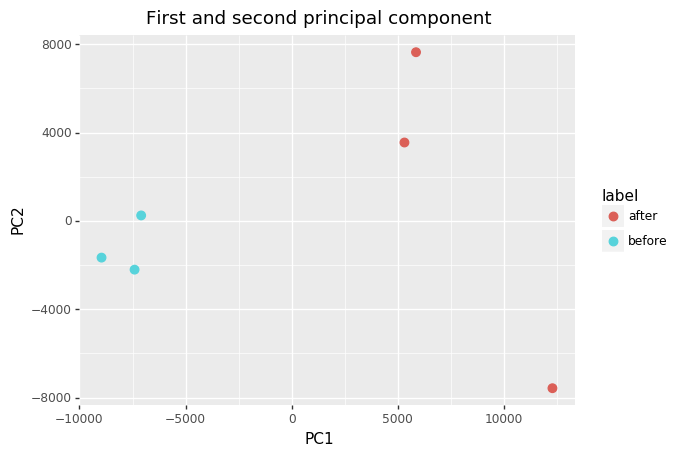

<ggplot: (7548741994)>

In [5]:
#graph PCA 
chart = ggplot(dataframe, aes(x='PC1', y='PC2', color='label') ) \
        + geom_point(size=3,alpha=1) \
        + ggtitle("First and second principal component")
chart

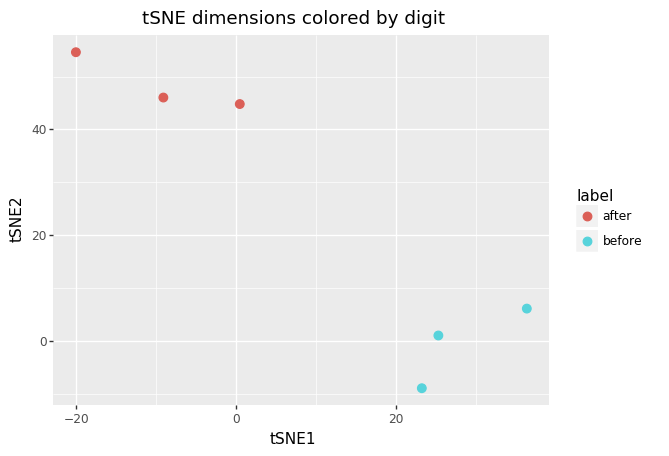

<ggplot: (7549237203)>

In [6]:
# graph t-SNE
chart = ggplot(dataframe, aes(x='tSNE1', y='tSNE2', color='label') ) \
        + geom_point(size=3,alpha=1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In both our PCA and our t-SNE graph, we can see a clear distinction between the before-caffeine cluster and the after-caffeine cluster! This indicates that caffeine is changing transcriptome state as the yeast is reacting to the caffeine in its environment on the transcriptome level.

Although PCA and t-SNE is often only helpful to indicate that transcripts are being differentially expressed, it is still a crucial first step in data analysis. After this, scientists will often use [heatmaps](https://en.wikipedia.org/wiki/Heat_map), [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling), [statistical tests] (https://pachterlab.github.io/sleuth_walkthroughs/trapnell/analysis.html), or other techniques to continue exploring the secrets hidden within the data. We invite you to continue learning about different crucial methods used by researches and to continue investigating how yeast uses gene regulation to respond to chemical changes in its environment.

# Additional Resources

- If you are interested in annotation files (`.gff3`), which identify the locations of genes on the genome and the functions of genes, [UCSC Genome Bioinformatics](http://hgdownload.soe.ucsc.edu/downloads.html) is a great starting place to find annotations for your organism.
- more technical information on the paired-end sequencing samples used in the original paper can be found [here](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA385168) and [here](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?run=SRR5511057). 
- another common pipline you can explore is: Trimmomatic/STAR/[HTseq](https://htseq.readthedocs.io/en/release_0.11.1/), this provides the expression of transcripts in *counts*, which is great for learning how to do statistical analysis on sequencing data
  